# **YouTube Sentiment**

---
*By Nicholas Castellana and Sheng-Hao Huang*

For our project we chose to analyze sentiment of the comments of the most popular Youtube videos. 


# **Libraries**

---

We start by importing the libraries we will need for this project. Other than the standard libraries, we used pickle to store our data structures, sklearn to run KMeans, and nltk for sentiment analysis.

In [ ]:
import requests
import json
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# **Utilities**

---

The following are some utility helper functions that we will rely on later. read_api_key is from homework 1 and reads a file where we store our API key for the YouTube Data V3 API. create_queries reads and formats queries from the supplied file of stop words, adding some extra custom queries that we found to be very effective. These queries all include terms that exclude videos with either "music" or "vevo" in the title or description, for reasons we will explain in the data collection section. hasEnoughViews(videoID) checks if the video with the supplied videoID has more than 10 million views. 

In [2]:
def read_api_key(filepath):
    """
    Reads filepath for an api key.
    
    Args:
        filepath (str): path to api key file
    
    Returns:
        api_key (str): api key
    """
    
    with open(filepath) as f:
        return f.read().replace('\n','')

def create_queries(filepath):
    """
    Creates a list of youtube queries using a stopwords and custom queries.
    
    Args:
        filepath (str): path to file with stop words, one per line
    
    Returns:
        result (list): list of api queries
    """
    
    result = []
    
    # add stop words to result
    with open(filepath) as f:
        queries = [line.strip() for line in f]
    result += [x + " -music" for x in queries]
    result += [x + " -vevo" for x in queries]
        
    # add custom queries to result
    result += ["site:youtube.com -music", # search all of youtube, exclude "music"
               "site:youtube.com -music -live", # exclude "live" also
               "site:youtube.com -music -live -vevo", # exclude "vevo" also
               "site:youtube.com -song -live", # variant of the first three queries, excluding "song"
               "site:youtube.com -music -live -vevo -song", # exclude everything
               "site:youtube.com a|i -vevo -album"] # any video with "a" or "i", excluding "vevo" and "album"
        
    return result
  
def hasEnoughViews(videoId):
    """
    Determines if a video has enough views, given its id.
    
    Args:
        videoId (str): youtube id for the video
    
    Returns:
        retval (bool): True if the video has 10 Million Views, None if video is a live video
                       False otherwise
    """
    
    # get html for video
    youtube_video = requests.request("GET", "https://www.youtube.com/watch?v=" + videoId).text
    
    # try to find view count
    left = youtube_video.find('<div class="watch-view-count">')
    right = youtube_video.find(" views</div>\n")
    views = youtube_video[left + len('<div class="watch-view-count">'):right].replace(",","")
    
    # if view count, either a live video or video got taken down
    if (left == -1 or right == -1):
        return None
    
    # return views
    retval = int(views) >= 10000000
    return retval

# **Data Collection**

---

Looking through the most popular videos on YouTube, we realized that most of them were music videos. Since people usually have positive reactions to music, we decided to exclude music videos as much as possible in our search, to make our project more interesting. This was done with terms like "-music" and "-vevo" in our search queries.

The following class is how we decided to format our data collection. videoDescriptor takes a videoID on initialization and collects all the data for that video using the setX(video_html) functions. We need another api call to obtain comments data, so that is located in the setComments method. Additionally, sentiment analysis is performed at this stage within the setDescription and setComments methods. We encapsulate all of the functionality into the getObject function, which returns the corresponding videoDescriptor when given a videoID.

In [3]:
class videoDescriptor:
    
    def __init__(self, videoId):
        self.videoId = videoId
        
        # html for youtube video
        youtube_video = requests.request("GET", "https://www.youtube.com/watch?v=" + videoId).text
        
        # video characteristics
        self.title = ""
        self.views = 0
        self.likes = 0
        self.dislikes = 0
        self.channelSubs = 0
        self.description = ""
        self.comments = []
        
        # four sentiment values for comment (averaged) and description,
        # along with standard deviations for the comment values
        self.description_positive = 0.0
        self.description_negative = 0.0
        self.description_neutral = 0.0
        self.description_compound = 0.0
        self.comment_positive = 0.0
        self.comment_negative = 0.0
        self.comment_neutral = 0.0
        self.comment_compound = 0.0
        self.comment_compoundSD = 0.0
        self.comment_positiveSD = 0.0
        self.comment_negativeSD = 0.0
        self.comment_neutralSD = 0.0
        
        # set all attributes, checking if video is still up
        self.setTitle(youtube_video)
        if self.title == None:
            return
        self.setViews(youtube_video)
        if self.views == None:
            return
        self.setLikes(youtube_video)
        self.setDislikes(youtube_video)
        self.setChannelSubs(youtube_video)
        self.setDescription(youtube_video)
        self.setComments()
        
    def setTitle(self, video_html):
        """
        Finds the title from the video html. And sets self.title to be 
        this value.
        
        Args: 
            video_html (str): the html of the video.
        """
        left = video_html.find('<meta name="title" content="')
        left += len('<meta name="title" content="')
        # check if video is still up
        if (left == -1):
            self.title = None
            return
        right = left
        while (video_html[right + 1:right + 3] != '">'):
            right += 1
        title = video_html[left:right+1]
        self.title = title
    
    def setViews(self, video_html):
        """
        Finds the view count from the video html. And sets
        self.views to be this value.
        
        Args: 
            video_html (str): the html of the video
        """
        left = video_html.find('<div class="watch-view-count">')
        # check if video is still up
        if (left == -1):
            self.views = None
            return
        right = video_html.find(" views</div>\n")
        views = video_html[left + len('<div class="watch-view-count">'):right].replace(",","")
        self.views = int(views)
    
    def setLikes(self, video_html):
        """
        Finds the like count from the video html. And sets
        self.likes to be this value.
        
        Args: 
            video_html (str): the html of the video
        """
        left = video_html.find('"like this video along with ')
        left += len('"like this video along with ')
        right = left
        while (video_html[right + 1] != " "):
            right += 1
        likes = video_html[left:right+1].replace(",","")
        self.likes = int(likes)
    
    def setDislikes(self, video_html):
        """
        Finds the dislike count from the video html. And sets
        self.dislikes to be this value.
        
        Args: 
            video_html (str): the html of the video
        """
        left = video_html.find('"dislike this video along with ')
        left += len('"dislike this video along with ')
        right = left
        while (video_html[right + 1] != " "):
            right += 1
        dislikes = video_html[left:right+1].replace(",","")    
        self.dislikes = int(dislikes)
    
    def setChannelSubs(self, video_html):
        """
        Finds the subscriber count of the channel that posted the video
        with the given html. And sets self.channelSubs to be this value.
        
        Args: 
            video_html(str): the html of the video
        """
        left = video_html.find('class="yt-subscription-button-subscriber-count-branded-horizontal yt-subscriber-count" title="')
        left += len('class="yt-subscription-button-subscriber-count-branded-horizontal yt-subscriber-count" title="')
        right = left
        while (video_html[right + 1] != '"'):
            right += 1
        subs = video_html[left:right+1]
        if (subs.isdigit()):
            self.channelSubs = int(float(subs))
        elif (subs[-1] == "K"):
            self.channelSubs = int(float(subs[:-1]) * 1000)
        elif (subs[-1] == "M"):
            self.channelSubs = int(float(subs[:-1]) * 1000000)
    
    def setDescription(self, video_html):
        """
        Finds the description of the video from the html. Then runs
        sentiment analysis. The results of this anaylsis are saved in 
        self.description_positive, self.description_negative,
        self.description_neutral, and self.description_compound.
        
        Args: 
            video_html (str): the html of the video
        """
        left = video_html.find('<meta name="description" content="')
        left += len('<meta name="description" content="')
        right = video_html.find('">\n\n      <meta name="keywords"')
        description = video_html[left:right+1]
        self.description = description
        
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(description)
        self.description_positive = ss['pos']
        self.description_negative = ss['neg']
        self.description_neutral = ss['neu']
        self.description_compound = ss['compound'] 
    
    def setComments(self):
        """
        Obtains the comments on a given video, with videoID stored at 
        videoID stored at self.videoID. Stores results in
        self.comment_positive, self.comment_negative,
        self.comment_neutral, self.comment_compound,
        self.comment_positiveSD, self.comment_negativeSD,
        self.comment_neutralSD, and self.comment_compoundSD.
        """
        part = "snippet"
        maxResults = 50
        order = "relevance"
        textFormat = "plainText"
        api_key = read_api_key('api_key.txt')
        
        comment_info = requests.request("GET", "https://www.googleapis.com/youtube/v3/commentThreads?key=%s&textFormat=%s&part=%s&videoId=%s&maxResults=%d&order=%s" %
                                        (api_key, textFormat, part, self.videoId, maxResults, order))
        
        result = comment_info.text
        comment_info.close()
        
        comments = []
        
        data = json.loads(result)
        if 'error' in data.keys():
            return
        size = len(data["items"])
        for i in range(size):
            comments.append(data["items"][i]["snippet"]["topLevelComment"]["snippet"]["textDisplay"])
        self.comments = comments
        
        sid = SentimentIntensityAnalyzer()
        positives = np.empty([size])
        negatives = np.empty([size])
        neutrals = np.empty([size])
        compound = np.empty([size])
        for i in range(len(comments)):
            ss = sid.polarity_scores(comments[i])
            positives[i] = (ss["pos"])
            negatives[i] = (ss["neg"])
            neutrals[i] = (ss["neu"])
            compound[i] = (ss["compound"])
        self.comment_positive = np.average(positives)
        self.comment_negative = np.average(negatives)
        self.comment_neutral = np.average(neutrals)
        self.comment_compound = np.average(compound)
        self.comment_positiveSD = np.std(positives)
        self.comment_negativeSD = np.std(negatives)
        self.comment_neutralSD = np.std(neutrals)
        self.comment_compoundSD = np.std(compound)
        
def getObject(videoId):
    """
    Creates a videoDescriptor object, given the relevant videoID
    
    Args: 
        videoID (str): the videoID of the video to create a 
                       videoDescriptor object for
    
    Returns: 
        resultant videoDescriptor object
    """
    return videoDescriptor(videoId)

Now we need some videos! To do this we need the results from queries. youtube_search takes an api_key, and the query to search. The pageToken argument is passed to the YouTube api in order to go to the next page of results in the case that we have multiple pages of videos that have at least 10 million views, and is returned when a current page is loaded. youtube_search also writes these videoIds to a text file. This allows us to just read from the text file the next time we load up this notebook, saving us excess api calls, conserving around 3 hours of time, and providing us a save point to restart from if the youtube_search function ever crashes.

In [4]:
def youtube_search(api_key, query, pageToken = None):
    """
    Using the YouTube Data V3 API, searches YouTube with the given
    query and api key. Writes results into videoID_list.txt
    
    Args:
        api_key (str): the api key to use to make the api calls
        query (str): the query to search on YouTube
        pageToken (str): a token returned by the API for the 
                         next page of results, or None if first 
                         page is desired. 
    
    Returns:
        videos (list): a list of videoIDs returned by the search
    """
    
    # set some parameters
    part = "id"
    maxResults = 50
    type_param = "video"
    order = "viewCount"
    textFormat = "plainText"
    
    # use pageToken if given
    if (pageToken == None):
        youtube_info = requests.request("GET", "https://www.googleapis.com/youtube/v3/search?key=%s&part=%s&maxResults=%d&q=%s&type=%s&order=%s&textFormat=%s" %
                                (api_key, part, maxResults, query, type_param, order, textFormat),
                                   params ={'q':query})
    else:
        youtube_info = requests.request("GET", "https://www.googleapis.com/youtube/v3/search?key=%s&part=%s&maxResults=%d&q=%s&type=%s&order=%s&textFormat=%s" %
                                (api_key, part, maxResults, query, type_param, order, textFormat),
                                   params = {'q':query, 'pageToken': pageToken})
    # get html
    result = youtube_info.text
    youtube_info.close()
    
    # init next page token and data
    data = json.loads(result)
    if 'nextPageToken' in data.keys():
        nextPageToken = data['nextPageToken']
    else:
        nextPageToken = None
    videos = []
    
    # write video Id to file if enough views and appends to videos array
    with open("videoID_list.txt", "a") as myfile:
        i = 0
        hasViews = True
        while (i < len(data['items']) and hasViews):
            videoID = data['items'][i]['id']['videoId']
            hasViews = hasEnoughViews(videoID)
            if (hasViews):
                videos.append(videoID)
                myfile.write(videoID + "\n")
            elif (hasViews == None):
                hasViews = True
            i += 1
            
    # recursive call if more valid videos
    if (hasViews and nextPageToken != None):
        youtube_search(api_key, query, pageToken=nextPageToken)
    
    return videos

Now that we defined our videoDescriptor object and our youtube_search process, it's time to put them together. First, we collect videoIDs. As mentioned before, we want this block of code isolated, so we only have to run the data collection ONCE, so that once we have the data we can simply read it from the file where the videoIDs are saved. In our loop, we print the query youtube_search is currently working on, so you can track it's progress.

In [0]:
""" NOTE: make sure videoID_list.txt is empty/deleted BEFORE running this,
          since youtube_search appends to the existing version"""
for query in create_queries("stopwords.txt"):
    print(query)
    youtube_search(read_api_key('api_key.txt'), query)

Next, we read from the newly created file and place all the videoIDs in a set, to eliminate duplicates. We then look at how many videoIDs we have collected to confirm that we have a good amount of data. There are nearly 6000 unique videoIDs, which is a good amount.

In [5]:
videoID_set = set()
with open("videoID_list.txt", "r") as myfile:
    for line in myfile:
        videoID_set.add(line.strip())

print(len(videoID_set))

5965


Now that we have removed duplicates, it's time to construct the dictionary of videoIDs to videoDescriptors. While we are doing this, we check to for ids to videos that don't have the right html and place any such ids into a list so we can examine what is going on with these videos. Once this is done we save the dictionary to a pickle file.

In [9]:
videoID_list = sorted(list(videoID_set))
video_dictionary = {}
bad_IDs = []
for index,videoID in enumerate(videoID_list):
    # this is where the heavy lifting happens
    o = getObject(videoID)
    # uncomment following line to track progress
    # print(index)
    if (o.title != None and o.views != None):
        video_dictionary[videoID] = o
    else:
        # only gets here if video is invalid in some way
        bad_IDs.append(videoID)
    
with open('video_dictionary.pickle', 'wb') as handle:
    pickle.dump(video_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(len(video_dictionary.keys()))
print(bad_IDs)

5965
[]


# **Processing the Data**

---

Now that we have videoIds and all the data that goes with them, it's time to process. We do this in two functions. createDataArray takes a list of videoIDs and a dictionary of videoIDs to videoDescriptor objects. It then creates a numpy array that is formatted to be passed to the KMeans function in sklearn, where the data is 8-dimensional: as seen in lines 5-8 below. Then we take this numpy array and run KMeans on it in the getLabels function, which returns the result from running KMeans in sklearn. You'll see we choose to use 15 clusters. This was decided after we experimented with different cluster amounts to get the best clustering. 

In [10]:
def createDataArray(videoDict, videoIDList):
    """
    Creates data array to be used for KMeans clustering
    
    Args:
        videoDict (dictionary): dictionary mapping videoIDs, and 
            specifically the videoIDs in videoIDList, to videoDescriptors
        videoIDList (list): list of videoIDs 
        
    Returns:
        rows (np.array): array of data formatted to be 
            used for KMeans clustering
    """
    rows = []
    for videoID in videoIDList:
        videoObject = videoDict[videoID]
        rows.append([videoObject.comment_positive, videoObject.comment_negative, 
                     videoObject.comment_neutral, videoObject.comment_compound,
                     videoObject.comment_positiveSD, videoObject.comment_negativeSD, 
                     videoObject.comment_neutralSD, videoObject.comment_compoundSD])
    return np.array(rows)

def getLabels(videoArray):
    """
    Runs KMeans clustering on the given array and returns the labels
    
    Args:
        videoArray (np.array): array of data to run KMeans clustering on
        
    Returns:
        kmeans (np.array): array of label values returned by the 
            sklearn implementation of KMeans
    """
    kmeans = KMeans(n_clusters=15, random_state=0).fit(videoArray)
    return kmeans.labels_

Once all the data has been collected, if this isn't the first time running the notebook, we load it from the pickle file. Then we format it in line 4 and run KMeans on line 5. We save the labels from running kmeans so that anyone reading this notebook can view the exact same data that we arrived at, avoiding the random convergence of kmeans.

In [27]:
with open('video_dictionary.pickle', 'rb') as handle:
    loaded_video_dictionary = pickle.load(handle)

data = createDataArray(loaded_video_dictionary, videoID_list)
labels = getLabels(createDataArray(loaded_video_dictionary, videoID_list))

with open('labels.pickle', 'wb') as handle:
    pickle.dump(labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('labels.pickle', 'rb') as handle:
    labels = pickle.load(handle)
   
print(labels.shape)

(5965,)


# **Visualization**

---

Now that we have collected and processed our data, we need to analyze the results. We do this in 5 steps. 

**Step #1: Initialize Variables**

---

We first create empty arrays that match the shape of the data we want to plot. 

In [28]:
clusters = []
titles = [[] for i in range(15)]
description_compound = [[] for i in range(15)]
description_positive = [[] for i in range(15)]
description_negative = [[] for i in range(15)]
description_neutral = [[] for i in range(15)]
likes = [[] for i in range(15)]
channelSubs = [[] for i in range(15)]

**Step  #2: Fill the Arrays**

---

Here we arrange the datas by cluster, and load into the appropriate array. We also create files that contain all the video titles for each cluster so we can go examine the clusters ourselves. titleX.txt corresponds to cluster X.

In [29]:
# load into appropriate arrays and subarrays for each cluster
for i in range(15):
    indexes = np.where(labels == i)[0]
    clusters.append(data[indexes])
    for j in indexes:
        titles[i].append(loaded_video_dictionary[videoID_list[j]].title)
        description_compound[i].append(loaded_video_dictionary[videoID_list[j]].description_compound)
        description_positive[i].append(loaded_video_dictionary[videoID_list[j]].description_positive)
        description_negative[i].append(loaded_video_dictionary[videoID_list[j]].description_negative)
        description_neutral[i].append(loaded_video_dictionary[videoID_list[j]].description_neutral)
        likes[i].append(loaded_video_dictionary[videoID_list[j]].likes / 
                        loaded_video_dictionary[videoID_list[j]].dislikes)
        channelSubs[i].append(loaded_video_dictionary[videoID_list[j]].channelSubs)
        
# collect the titles in text files for each cluster
for i,title_list in enumerate(titles):
    filename = "title" + str(i) + ".txt"
    with open(filename, "w", encoding="utf-8") as f:
        for title in title_list:
            f.write(title + "\n")

**Step #3: Cluster Graphs**

---

Before graphing, we made a dictionary so that titles of axes can be created inside loops. Then, for the first set of graphs, we create a 4 x 15 grid of graphs, with each column being a different dimension of sentiment (Positive, Negative, Neutral, and Compound), each row being a different cluster (note the graphs for cluster 2 are just a point due to having no comments), and each graph is average sentiment vs. standard deviation.

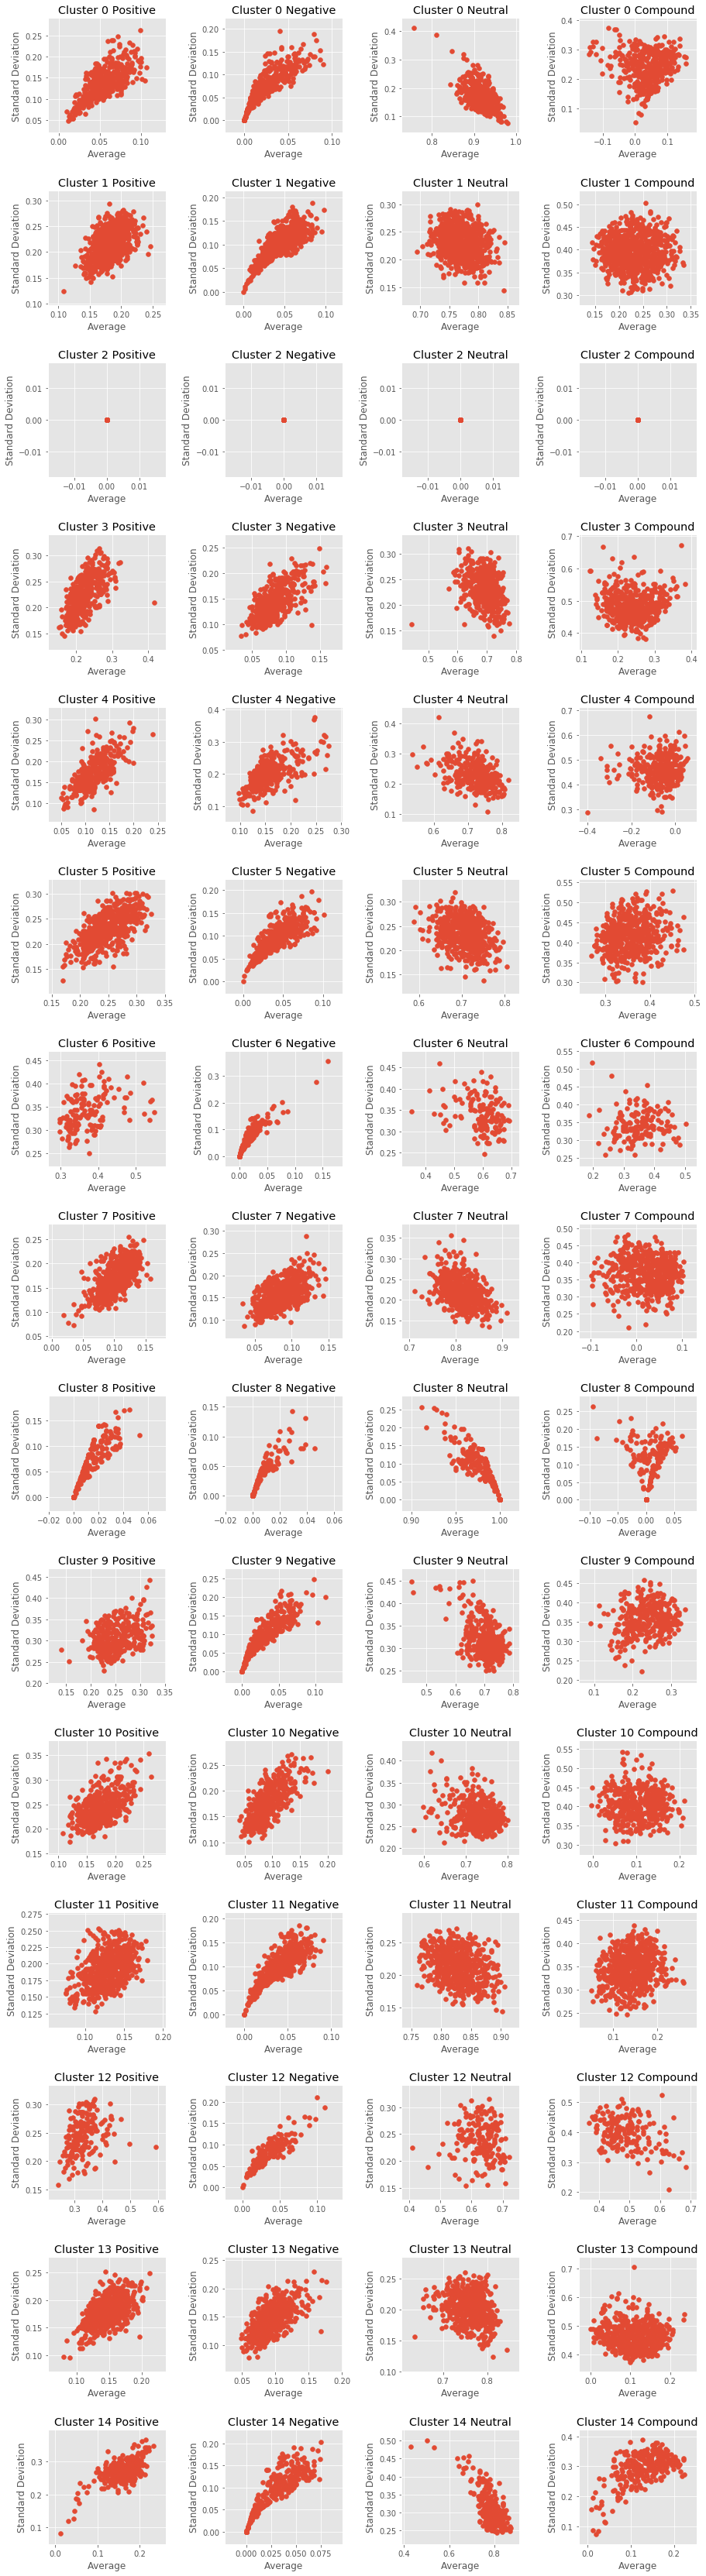

In [32]:
axis = {0:'Positive', 1:'Negative', 2:'Neutral', 3:'Compound'}
f, axarr = plt.subplots(15,4,figsize=(15,60))
for c in range(15):
    for d in range(4):
        axarr[c,d].scatter(clusters[c][:,d],clusters[c][:,d+4])
        axarr[c,d].set_xlabel('Average')
        axarr[c,d].set_ylabel('Standard Deviation')
        axarr[c,d].set_title("Cluster "+ str(c) + " " + axis[d])
f.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

In general, you can see that in each cluster, higher positive and negative averages correlated with higher standard deviation in the sentiment of comments, meaning the polarity in sentiment between comments was higher. The converse is true for the neutral average, which is what we would expect.

As mentionted before, cluster 2 shows video that have comments disabled. We initially thought these would be extremely controversial videos, and some of them are, but a lot of them are just normal videos like “The Six Coworkers You’ll Have at Your Job” and “National Anthem USA (ALL VERSES)”.

One cluster that stands out is cluster 4. The comments for the videos in this cluster were significantly more negative than those for videos in other clusters. Some titles from this cluster include:

- 10 Kids Who Grew Up In Prison
- You’re Doing it Wrong || Fail Compilation by FailArmy 2016
- So Sorry. (Logan Paul)
- Hawkeye Disappoints the Avengers - SNL
- Titanic sinks in REAL TIME - 2 HOURS 40 MINUTES

Another cluster that stands out is cluster 6. The opposite from cluster 4 applies here:

- The Most Beautiful Thing (Short Film)
- The Most DANGEROUS and STRANGEST AIRPORTS in the WORLD! Most Amazing and Crosswind Landings!
- Our Best Toy Car Compilation Video for Kids!
- 22 CHRISTMAS DECOR AND GIFT IDEAS WITHOUT GOING BROKE
- Let's Count to 20 Song For Kids

Now we can create more sets of graphs. First we have the same 4x15 grid, but this time the graphs are sentiment average vs description sentiment.

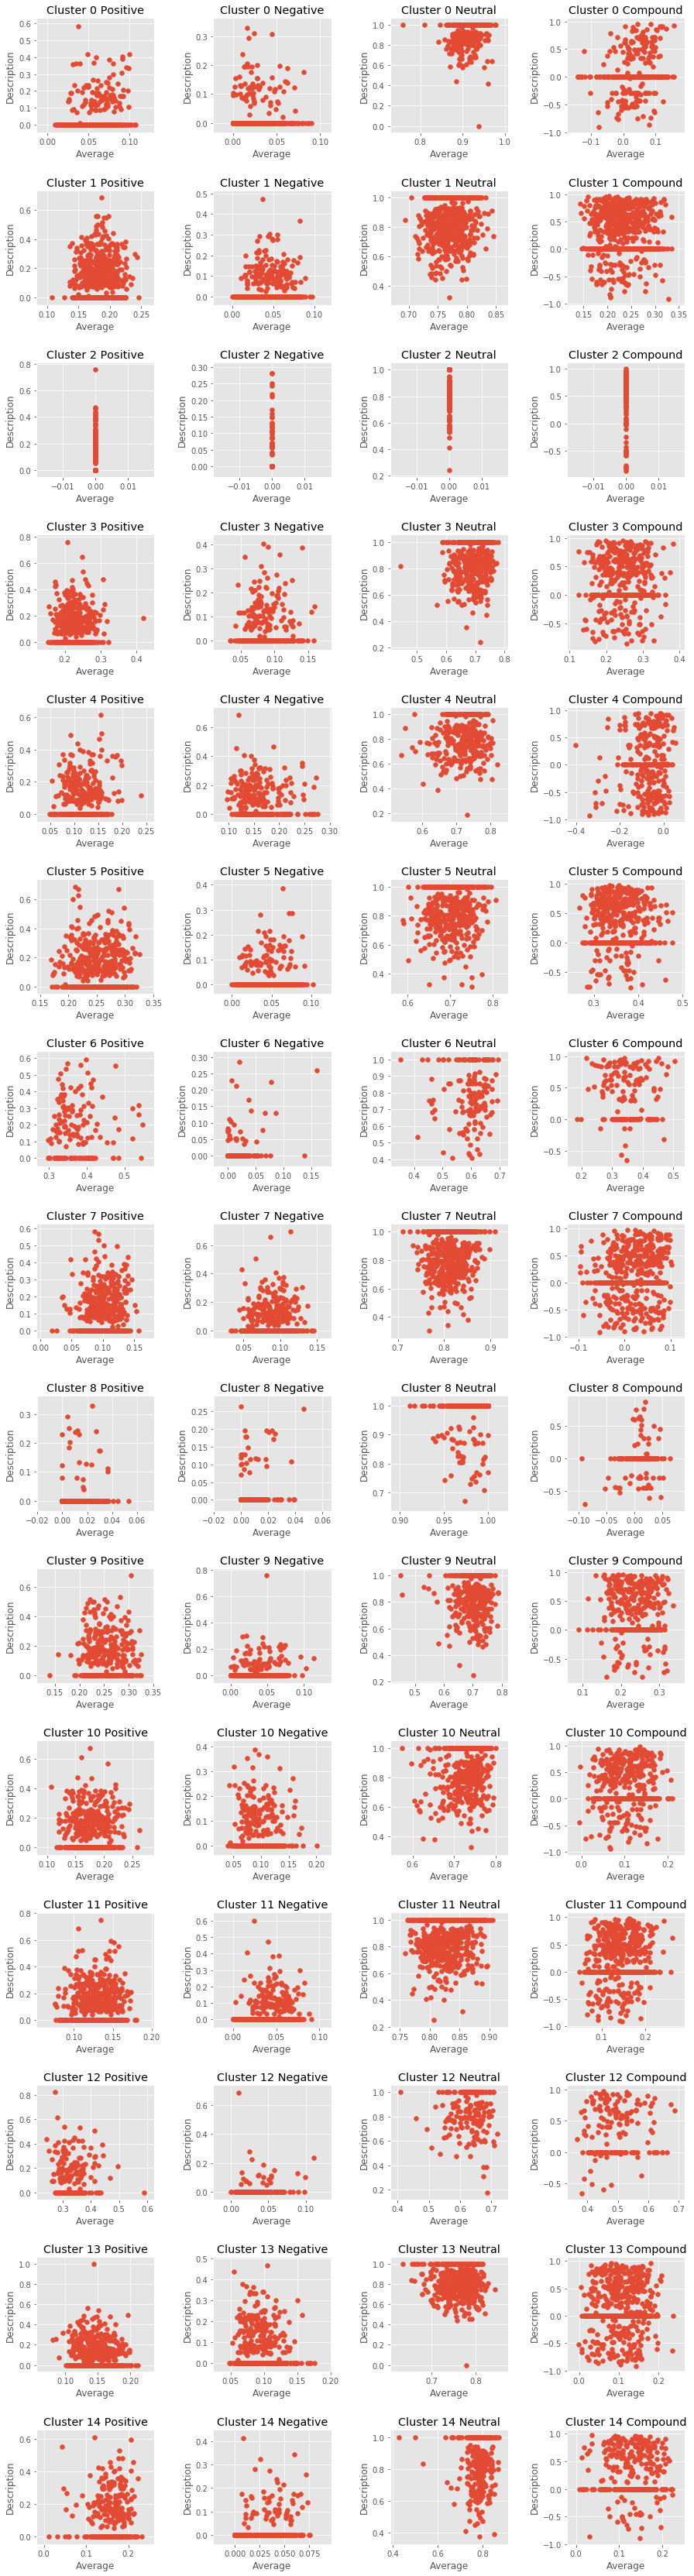

In [33]:
f1, axarr1 = plt.subplots(15,4,figsize=(15,60))
for c in range(15):
    axarr1[c,3].scatter(clusters[c][:,3],description_compound[c])
    axarr1[c,3].set_xlabel('Average')
    axarr1[c,3].set_ylabel('Description')
    axarr1[c,3].set_title("Cluster "+ str(c) + " " + axis[3])
    axarr1[c,0].scatter(clusters[c][:,0],description_positive[c])
    axarr1[c,0].set_xlabel('Average')
    axarr1[c,0].set_ylabel('Description')
    axarr1[c,0].set_title("Cluster "+ str(c) + " " + axis[0])
    axarr1[c,1].scatter(clusters[c][:,1],description_negative[c])
    axarr1[c,1].set_xlabel('Average')
    axarr1[c,1].set_ylabel('Description')
    axarr1[c,1].set_title("Cluster "+ str(c) + " " + axis[1])
    axarr1[c,2].scatter(clusters[c][:,2],description_neutral[c])
    axarr1[c,2].set_xlabel('Average')
    axarr1[c,2].set_ylabel('Description')
    axarr1[c,2].set_title("Cluster "+ str(c) + " " + axis[2])
f1.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

The most obvious trend is that there are lots of neutral descriptions in each cluster. There is very little correlation between description and comment sentiment, which seems to indicate that people don’t really read descriptions. In some clusters the correlation stronger than others, but overall influence is still insignificant.

Next, the 4x15 grid again, but this time average sentiment vs the like to dislike ratio. 

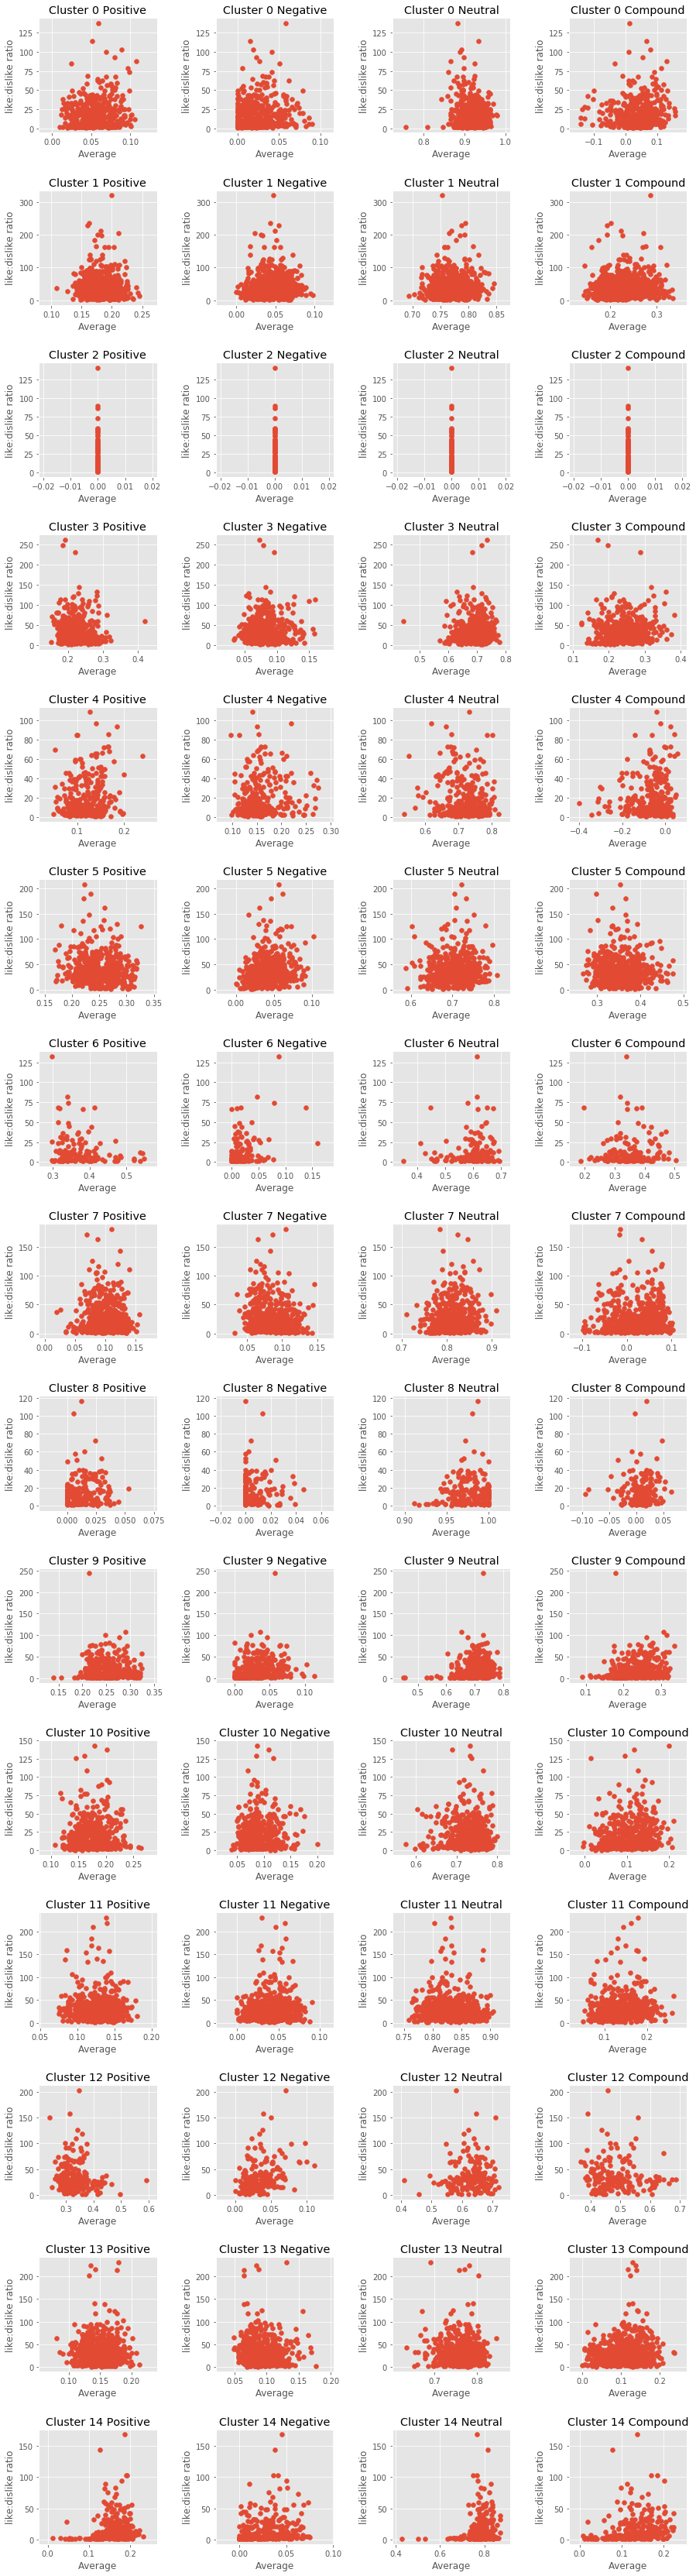

In [34]:
f2, axarr2 = plt.subplots(15,4,figsize=(15,60))
f2.subplots_adjust(hspace=.5,wspace=.5)

for c in range(15):
    axarr2[c,0].scatter(clusters[c][:,0],likes[c])
    axarr2[c,0].set_title("Cluster %d Positive" % c)
    axarr2[c,0].set_xlabel("Average")
    axarr2[c,0].set_ylabel("like:dislike ratio")
    axarr2[c,1].scatter(clusters[c][:,1],likes[c])
    axarr2[c,1].set_title("Cluster %d Negative" % c)
    axarr2[c,1].set_xlabel("Average")
    axarr2[c,1].set_ylabel("like:dislike ratio")
    axarr2[c,2].scatter(clusters[c][:,2],likes[c])
    axarr2[c,2].set_title("Cluster %d Neutral" % c)
    axarr2[c,2].set_xlabel("Average")
    axarr2[c,2].set_ylabel("like:dislike ratio")
    axarr2[c,3].scatter(clusters[c][:,3],likes[c])
    axarr2[c,3].set_title("Cluster %d Compound" % c)
    axarr2[c,3].set_xlabel("Average")
    axarr2[c,3].set_ylabel("like:dislike ratio")
plt.show()

We can see that in all the clusters, most of the videos have a like to dislike ratio within 50. This means that while likes to dislike ratios are usually greater than 1, the actual ratio isn't that overwhelming. This goes to show the amount of diversity in opinion among YouTube's viewers. 

Another observation we can make here is that regardless of average comment sentiment value, the amount of videos with high like to dislike ratios (above 50) remains about the same. Therefore, average comment sentiment value doesn't seem like a good indicator of a good like to dislike ratio.

Now we examine average sentiment vs channel subscriber count.

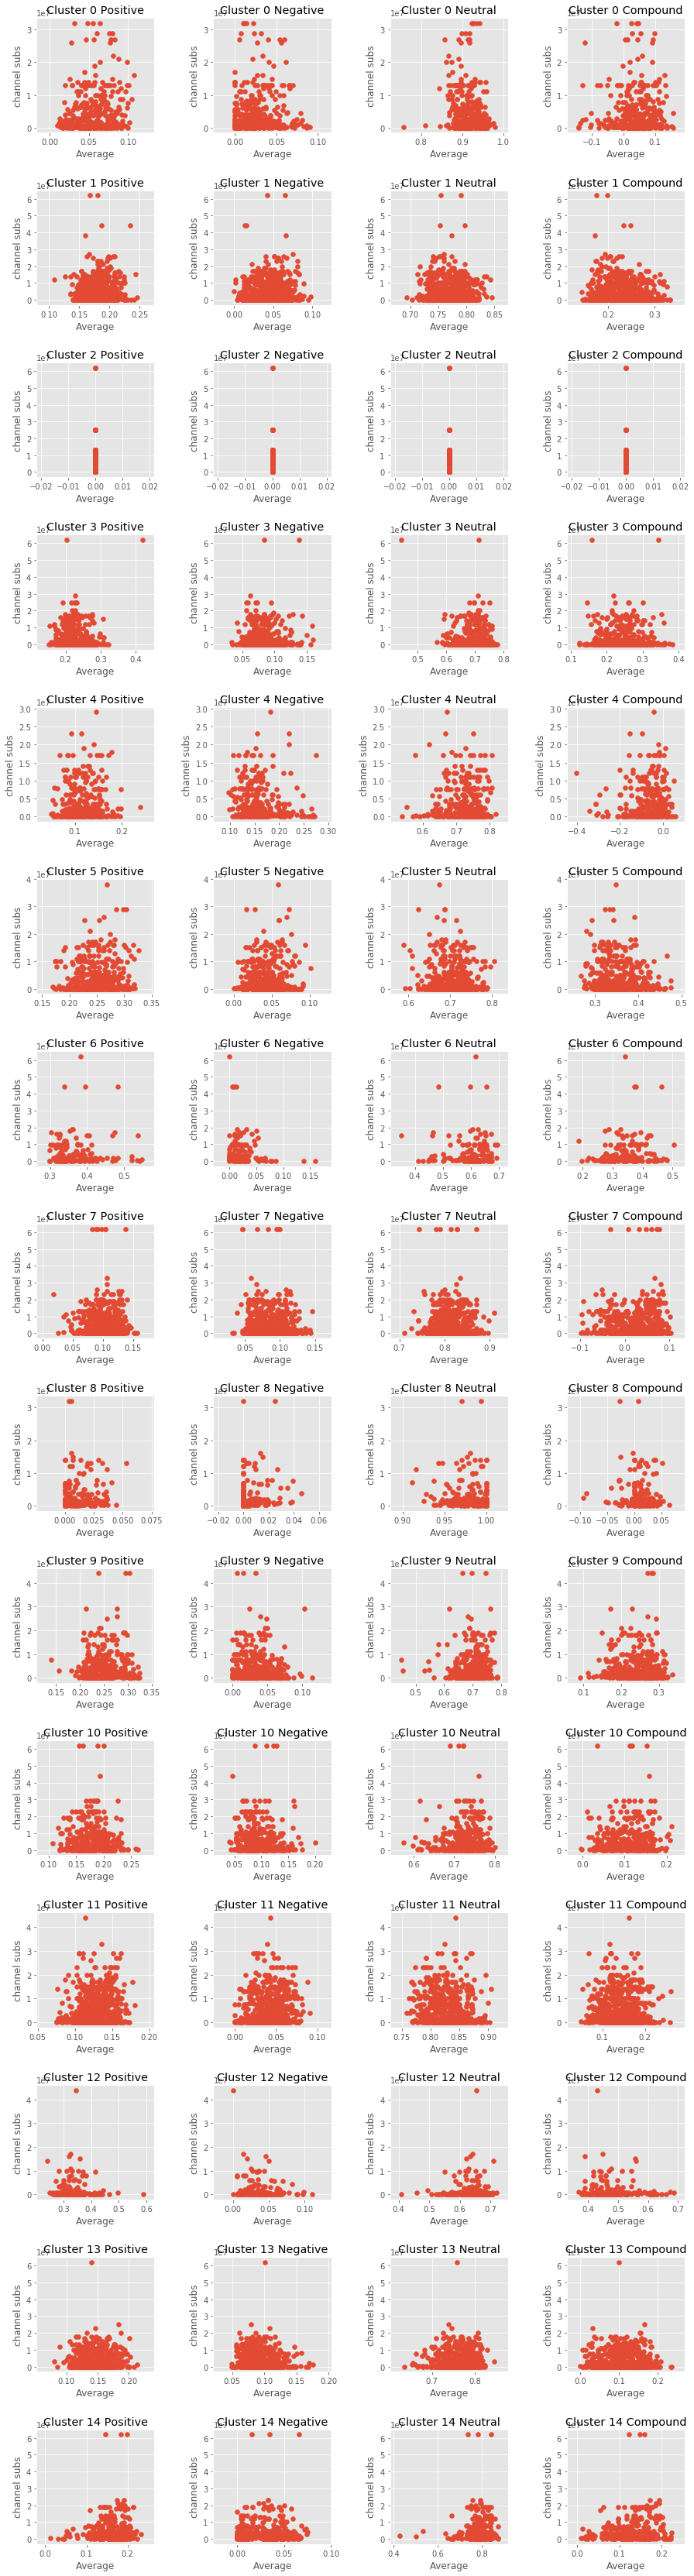

In [41]:
f3, axarr3 = plt.subplots(15,4,figsize=(15,60))
f3.subplots_adjust(hspace=.5,wspace=.5)
for c in range(15):
    axarr3[c,0].scatter(clusters[c][:,0],channelSubs[c])
    axarr3[c,0].set_title("Cluster %d Positive" % c)
    axarr3[c,0].set_xlabel("Average")
    axarr3[c,0].set_ylabel("channel subs")
    axarr3[c,1].scatter(clusters[c][:,1],channelSubs[c])
    axarr3[c,1].set_title("Cluster %d Negative" % c)
    axarr3[c,1].set_xlabel("Average")
    axarr3[c,1].set_ylabel("channel subs")
    axarr3[c,2].scatter(clusters[c][:,2],channelSubs[c])
    axarr3[c,2].set_title("Cluster %d Neutral" % c)
    axarr3[c,2].set_xlabel("Average")
    axarr3[c,2].set_ylabel("channel subs")
    axarr3[c,3].scatter(clusters[c][:,3],channelSubs[c])
    axarr3[c,3].set_title("Cluster %d Compound" % c)
    axarr3[c,3].set_xlabel("Average")
    axarr3[c,3].set_ylabel("channel subs")
plt.show()

The graphs here largely look pretty similar, which seems to imply that average sentiment of the comments doesn't really reflect on the subscriber count for the channel. This is unintuitive, as you'd expect the subscribers for a channel to voice support in the comments section for individual videos, but more on that later when we examine videos from channels with 1 million+ subscribers.

**Step #4: Auxiliary Data**

---

Create special arrays for just examining videos with over 100 Million views, or on channels with over 1 million subscribers.

In [45]:
hundredMplus_description_positive = []
hundredMplus_description_negative = []
hundredMplus_description_neutral = []
hundredMplus_description_compound = []
hundredMplus_comment_positive = []
hundredMplus_comment_negative = []
hundredMplus_comment_neutral = []
hundredMplus_comment_compound = []
hundredMplus_like_ratio = []
with open("hundredMplus_videos.txt", "w", encoding="utf-8") as f:
    for videoID in videoID_list:
        videoObject = loaded_video_dictionary[videoID]
        if (videoObject.views >= 1e8):
            hundredMplus_description_positive.append(videoObject.description_positive)
            hundredMplus_description_negative.append(videoObject.description_negative)
            hundredMplus_description_neutral.append(videoObject.description_neutral)
            hundredMplus_description_compound.append(videoObject.description_compound)
            hundredMplus_comment_positive.append(videoObject.comment_positive)
            hundredMplus_comment_negative.append(videoObject.comment_negative)
            hundredMplus_comment_neutral.append(videoObject.comment_neutral)
            hundredMplus_comment_compound.append(videoObject.comment_compound)
            hundredMplus_like_ratio.append(videoObject.likes/videoObject.dislikes)
            f.write(videoObject.title + "\n")

"""uncomment to view array averages"""
# print(np.mean(np.array(hundredMplus_description_positive)))
# print(np.mean(np.array(hundredMplus_description_negative)))
# print(np.mean(np.array(hundredMplus_description_neutral)))
# print(np.mean(np.array(hundredMplus_description_compound)))
# print(np.mean(np.array(hundredMplus_comment_positive)))
# print(np.mean(np.array(hundredMplus_comment_negative)))
# print(np.mean(np.array(hundredMplus_comment_neutral)))
# print(np.mean(np.array(hundredMplus_comment_compound))) 
    
oneMplus_description_positive = []
oneMplus_description_negative = []
oneMplus_description_neutral = []
oneMplus_description_compound = []
oneMplus_comment_positive = []
oneMplus_comment_negative = []
oneMplus_comment_neutral = []
oneMplus_comment_compound = []
oneMplus_like_ratio = []
oneMplus_subs = []
with open("oneMplus_videos.txt", "w", encoding="utf-8") as f:
    for videoID in videoID_list:
        videoObject = loaded_video_dictionary[videoID]
        if (videoObject.channelSubs >= 1e6):
            oneMplus_description_positive.append(videoObject.description_positive)
            oneMplus_description_negative.append(videoObject.description_negative)
            oneMplus_description_neutral.append(videoObject.description_neutral)
            oneMplus_description_compound.append(videoObject.description_compound)
            oneMplus_comment_positive.append(videoObject.comment_positive)
            oneMplus_comment_negative.append(videoObject.comment_negative)
            oneMplus_comment_neutral.append(videoObject.comment_neutral)
            oneMplus_comment_compound.append(videoObject.comment_compound)
            oneMplus_like_ratio.append(videoObject.likes/videoObject.dislikes)
            oneMplus_subs.append(videoObject.channelSubs)
            f.write(videoObject.title + "\n")
            
"""uncomment to view array averages"""
# print(np.mean(np.array(oneMplus_description_positive)))
# print(np.mean(np.array(oneMplus_description_negative)))
# print(np.mean(np.array(oneMplus_description_neutral)))
# print(np.mean(np.array(oneMplus_description_compound)))
# print(np.mean(np.array(oneMplus_comment_positive)))
# print(np.mean(np.array(oneMplus_comment_negative)))
# print(np.mean(np.array(oneMplus_comment_neutral)))
# print(np.mean(np.array(oneMplus_comment_compound)))

print("The number of hundred million+ view videos is: %d" % len(hundredMplus_description_positive))
print("The number of one million+ channel subscriber videos is: %d" % len(oneMplus_description_positive))

The number of hundred million+ view videos is: 204
The number of one million+ channel subscriber videos is: 3309


**Step #5: Graphs of Auxiliary Data**

---

Now we ditch the 4x15 grid for a 4x2 one. This is to examine only the videos with over 100 million views and see if different trends exist for these than the ones in the clusters. The first row is average sentiment vs like to dislike ratio, and the second is description sentiment vs like to dislike ratio.

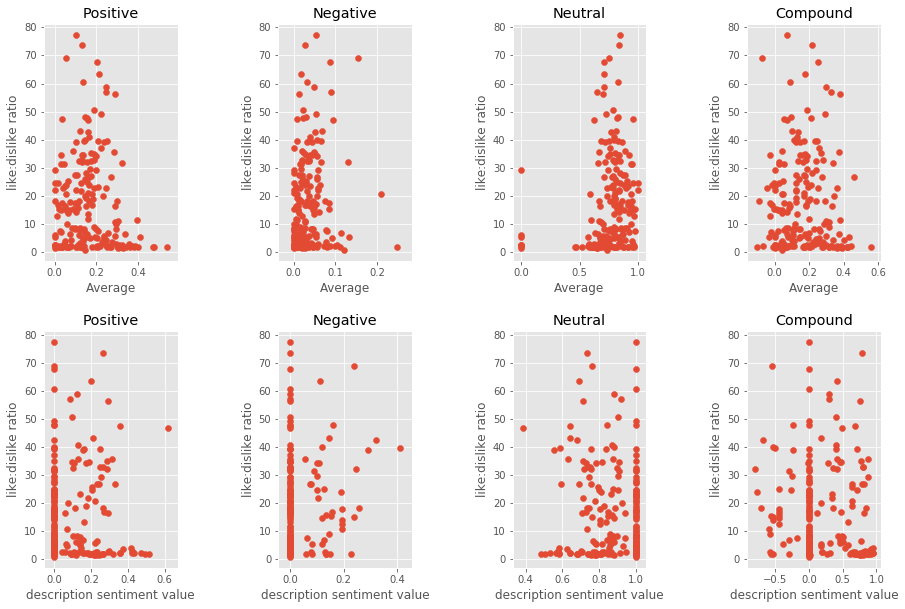

In [35]:
f4, axarr4 = plt.subplots(2, 4, figsize=(15,10))
f4.subplots_adjust(hspace=.3, wspace=.75)
axarr4[0,0].scatter(np.array(hundredMplus_comment_positive), np.array(hundredMplus_like_ratio))
axarr4[0,0].set_title("Positive")
axarr4[0,0].set_xlabel("Average")
axarr4[0,0].set_ylabel("like:dislike ratio")
axarr4[0,1].scatter(np.array(hundredMplus_comment_negative), np.array(hundredMplus_like_ratio))
axarr4[0,1].set_title("Negative")
axarr4[0,1].set_xlabel("Average")
axarr4[0,1].set_ylabel("like:dislike ratio")
axarr4[0,2].scatter(np.array(hundredMplus_comment_neutral), np.array(hundredMplus_like_ratio))
axarr4[0,2].set_title("Neutral")
axarr4[0,2].set_xlabel("Average")
axarr4[0,2].set_ylabel("like:dislike ratio")
axarr4[0,3].scatter(np.array(hundredMplus_comment_compound), np.array(hundredMplus_like_ratio))
axarr4[0,3].set_title("Compound")
axarr4[0,3].set_xlabel("Average")
axarr4[0,3].set_ylabel("like:dislike ratio")
axarr4[1,0].scatter(np.array(hundredMplus_description_positive), np.array(hundredMplus_like_ratio))
axarr4[1,0].set_title("Positive")
axarr4[1,0].set_xlabel("description sentiment value")
axarr4[1,0].set_ylabel("like:dislike ratio")
axarr4[1,1].scatter(np.array(hundredMplus_description_negative), np.array(hundredMplus_like_ratio))
axarr4[1,1].set_title("Negative")
axarr4[1,1].set_xlabel("description sentiment value")
axarr4[1,1].set_ylabel("like:dislike ratio")
axarr4[1,2].scatter(np.array(hundredMplus_description_neutral), np.array(hundredMplus_like_ratio))
axarr4[1,2].set_title("Neutral")
axarr4[1,2].set_xlabel("description sentiment value")
axarr4[1,2].set_ylabel("like:dislike ratio")
axarr4[1,3].scatter(np.array(hundredMplus_description_compound), np.array(hundredMplus_like_ratio))
axarr4[1,3].set_title("Compound")
axarr4[1,3].set_xlabel("description sentiment value")
axarr4[1,3].set_ylabel("like:dislike ratio")
plt.show()

With these extremely popular videos, descriptions tend to be a little more positive, and comments are on average less negative. What stands out is that there are still a decent amount of videos with negative desciptions, some of them fairly negative.

Another interesting trend to note is that the more neutral the comments/description are, the higher the like to dislike ratio. The neutrality of the comments could mean that more spam occurs in extremely popular videos. The neutrality of the description is hard to explain though, and is just an interesting trend to observe.

Looking at the video titles, most of them are covers:

- The Chipettes - Single Ladies [Put A Ring On It]
- Luis Fonsi - Despacito ( cover by J.Fla )
- Frozen - A Musical feat. Disney Princesses
- Four Seasons ~ Vivaldi

There's also some really random ones:

- &#39;INSIDE OUT&#39; Makeup Tutorial (Disgust,Sadness,Joy,Anger &amp; Fear)
- Adorable 3 year old is very happy to dance!
- The Amazing Spider-Man 2: The First 10 Minutes
- Charlie bit my finger - again !

Lastly we examine the videos with a subscriber count of over 1 million. The first row is average sentiment vs subscriber count and the second row is description sentiment vs subscriber count.

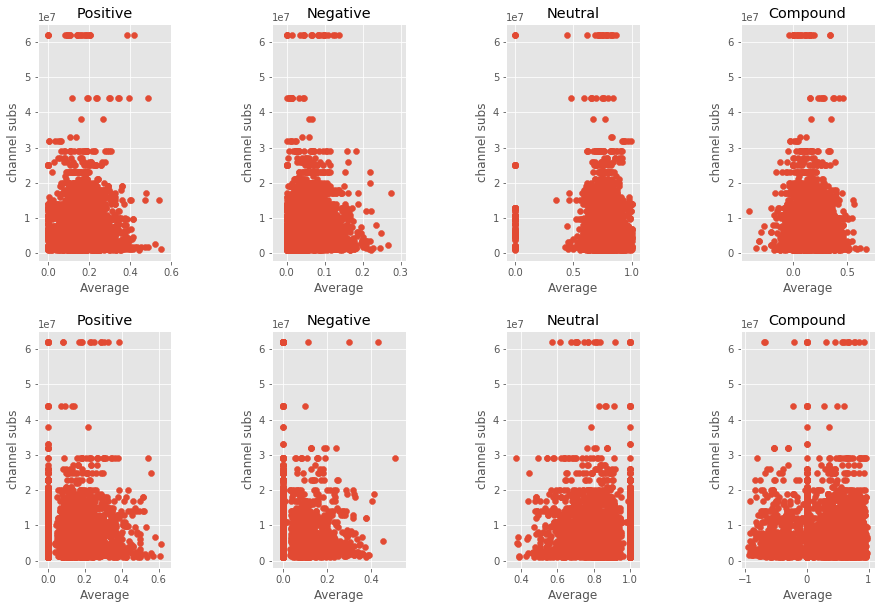

In [49]:
f5, axarr5 = plt.subplots(2,4, figsize=(15,10))
f5.subplots_adjust(hspace=.3, wspace=.75)
axarr5[0,0].scatter(np.array(oneMplus_comment_positive), np.array(oneMplus_subs))
axarr5[0,0].set_title("Positive")
axarr5[0,0].set_xlabel("Average")
axarr5[0,0].set_ylabel("channel subs")
axarr5[0,1].scatter(np.array(oneMplus_comment_negative), np.array(oneMplus_subs))
axarr5[0,1].set_title("Negative")
axarr5[0,1].set_xlabel("Average")
axarr5[0,1].set_ylabel("channel subs")
axarr5[0,2].scatter(np.array(oneMplus_comment_neutral), np.array(oneMplus_subs))
axarr5[0,2].set_title("Neutral")
axarr5[0,2].set_xlabel("Average")
axarr5[0,2].set_ylabel("channel subs")
axarr5[0,3].scatter(np.array(oneMplus_comment_compound), np.array(oneMplus_subs))
axarr5[0,3].set_title("Compound")
axarr5[0,3].set_xlabel("Average")
axarr5[0,3].set_ylabel("channel subs")
axarr5[1,0].scatter(np.array(oneMplus_description_positive), np.array(oneMplus_subs))
axarr5[1,0].set_title("Positive")
axarr5[1,0].set_xlabel("Average")
axarr5[1,0].set_ylabel("channel subs")
axarr5[1,1].scatter(np.array(oneMplus_description_negative), np.array(oneMplus_subs))
axarr5[1,1].set_title("Negative")
axarr5[1,1].set_xlabel("Average")
axarr5[1,1].set_ylabel("channel subs")
axarr5[1,2].scatter(np.array(oneMplus_description_neutral), np.array(oneMplus_subs))
axarr5[1,2].set_title("Neutral")
axarr5[1,2].set_xlabel("Average")
axarr5[1,2].set_ylabel("channel subs")
axarr5[1,3].scatter(np.array(oneMplus_description_compound), np.array(oneMplus_subs))
axarr5[1,3].set_title("Compound")
axarr5[1,3].set_xlabel("Average")
axarr5[1,3].set_ylabel("channel subs")
plt.show()

In these videos, the average comment sentiment values are a lot more polar, which shows that these highly-subbed channels get both a lot of love and a lot of hate. So while the people who sub do voice their love for the channel, they are also sometimes balanced by those who hate on the channel.

Some videos here are:
- &quot;MORE WALKING (AND TALKING) DEAD: PART 1&quot; - A Bad Lip Reading of The Walking Dead Season 4 by Bad Lip Reading
- Kris Jenner Plays Who&#39;d You Rather? by TheEllenShow
- Teens React to Nicki Minaj - Anaconda by FBE
- The Try Guys Try Not To Die At Sea // Sponsored by The Shallows by BuzzFeedVideo

# **Conclusion**

---

In this project, we made many interesting observations. Some met our expectations, but many were surprising. The trends we observed in the 100 million+ view count and 1 million+ subscriber count graphs were especially fun to examine. One of our biggest takeaways for this project was that YouTube is extremely diverse, from people with different opinions to bots and spammers. The sheer amount of videos that exist make even the search functionionality hard to grasp and control, making YouTube a rich but complex source of data to examine.

Thank you for your consideration of this project!